# Pemodelan Pertumbuhan Populasi (Logistic ODE) dengan RK4

## Tujuan
Membangun model pertumbuhan populasi berbasis **persamaan diferensial (ODE)** dan menyelesaikannya secara numerik menggunakan **Runge–Kutta orde 4 (RK4)**.  
Parameter model (**r** dan **K**) diestimasi dari data time series populasi sehingga kurva simulasi mendekati data (validasi).

## Dataset
File: `PopulationDataset.csv`  
Kolom utama yang dipakai: `Country`, `Year`, `Population`.

## Output utama
1. Grafik EDA: `Population vs Year` untuk 1 negara (studi kasus unik).
2. Estimasi parameter: `r_hat` dan `K_hat`.
3. Validasi: Grafik **Data vs Simulasi (RK4)** + metrik error (RMSE).
4. What-if: perubahan parameter untuk melihat dampak skenario.


In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize


## 1) Import library
- `pandas` untuk membaca dan memproses dataset.
- `numpy` untuk komputasi numerik.
- `matplotlib` untuk visualisasi.
- `scipy.optimize.minimize` untuk fitting parameter (estimasi r dan K).


In [7]:
PATH = "PopulationDataset.csv"  # sesuaikan jika path berbeda
df_raw = pd.read_csv(PATH)

print("SHAPE:", df_raw.shape)
print("COLUMNS:", list(df_raw.columns))
df_raw.head()


SHAPE: (4104, 14)
COLUMNS: ['Country', 'Year', 'Population', 'Yearly %', 'Change Yearly', 'Change Migrants (net)', 'Median Age', 'Fertility Rate', 'Density (P/Km²)', 'Urban Pop %', 'Urban Population', "Country's Share of World Pop", 'World Population', "Country's Global Rank"]


,Country,Year,Population,Yearly %,Change Yearly,Change Migrants (net),Median Age,Fertility Rate,Density (P/Km²),Urban Pop %,Urban Population,Country's Share of World Pop,World Population,Country's Global Rank
0,India,2024,"1,441,719,852",0.92 %,"13,092,189","-486,784",28.6,1.98,485,36.8 %,"530,387,142",17.76 %,"8,118,835,999",1.0
1,India,2023,"1,428,627,663",0.81 %,"11,454,490","-486,136",28.2,2.00,481,36.3 %,"518,239,122",17.76 %,"8,045,311,447",1.0
2,India,2022,"1,417,173,173",0.68 %,"9,609,331","-487,303",27.9,2.01,477,35.7 %,"506,304,869",17.77 %,"7,975,105,156",2.0
3,India,2020,"1,396,387,127",0.96 %,"13,275,077","-34,772",27.3,2.05,470,34.6 %,"483,098,640",17.81 %,"7,840,952,880",2.0
4,India,2015,"1,322,866,505",1.29 %,"16,450,577","-475,094",25.5,2.29,445,32.4 %,"429,069,459",17.81 %,"7,426,597,537",2.0


## 2) Load dataset
Memuat CSV dan menampilkan:
- ukuran data (baris, kolom),
- daftar kolom,
- 5 baris pertama untuk memastikan format data benar.


In [8]:
df = df_raw.copy()

# A) Filter Year yang valid (harus 4 digit, misal 2024, 2010, dst)
df = df[df["Year"].astype(str).str.match(r"^\d{4}$")].copy()
df["Year"] = df["Year"].astype(int)

# B) Fungsi konversi string angka yang punya koma/percent jadi numeric
def to_num(series):
    # hilangkan koma ribuan
    s = series.astype(str).str.replace(",", "", regex=False)
    # hilangkan spasi dan simbol persen kalau ada
    s = s.str.replace("%", "", regex=False).str.strip()
    return pd.to_numeric(s, errors="coerce")

# C) Parsing kolom numerik yang kita butuhkan
df["Population_num"] = to_num(df["Population"])

# (Opsional) Parsing beberapa kolom lain jika mau dipakai EDA tambahan
if "World Population" in df.columns:
    df["WorldPop_num"] = to_num(df["World Population"])

df = df.dropna(subset=["Population_num"])  # pastikan populasi valid
df[["Country", "Year", "Population", "Population_num"]].head(10)


,Country,Year,Population,Population_num
0,India,2024,"1,441,719,852",1441719852
1,India,2023,"1,428,627,663",1428627663
2,India,2022,"1,417,173,173",1417173173
3,India,2020,"1,396,387,127",1396387127
4,India,2015,"1,322,866,505",1322866505
5,India,2010,"1,240,613,620",1240613620
6,India,2005,"1,154,638,713",1154638713
7,India,2000,"1,059,633,675",1059633675
8,India,1995,"964,279,129",964279129
9,India,1990,"870,452,165",870452165


## 3) Data cleaning
Dataset ini memiliki:
- beberapa baris `Year` yang bukan angka (teks), sehingga harus difilter (hanya `YYYY`).
- angka populasi yang masih berbentuk string dengan pemisah ribuan (koma), sehingga perlu dibersihkan lalu dikonversi ke numeric.

Hasil tahap ini:
- `Year` bertipe `int`
- `Population_num` bertipe `float` dan siap dipakai untuk time series.


In [9]:
# Pilih 1 negara untuk studi kasus (unik untuk Orang 1)
COUNTRY = "Indonesia"  # ganti sesuai kebutuhan

sub = df[df["Country"] == COUNTRY][["Year", "Population_num"]].copy()
sub = sub.rename(columns={"Population_num": "Population"})
sub = sub.dropna().sort_values("Year").reset_index(drop=True)

print("COUNTRY:", COUNTRY)
print("N points:", len(sub))
sub.head(), sub.tail()


COUNTRY: Indonesia
N points: 17


(   Year  Population
 0  1955    77741502
 1  1960    88382881
 2  1965   101157868
 3  1970   115228394
 4  1975   131213215,
     Year  Population
 12  2015   259091970
 13  2020   271857970
 14  2022   275501339
 15  2023   277534122
 16  2024   279798049)

## 4) Memilih 1 negara (studi kasus unik)
Agar studi kasus jelas dan unik, kita fokus pada 1 negara saja.

Output `sub` adalah time series:
- `Year` (waktu)
- `Population` (observasi populasi)


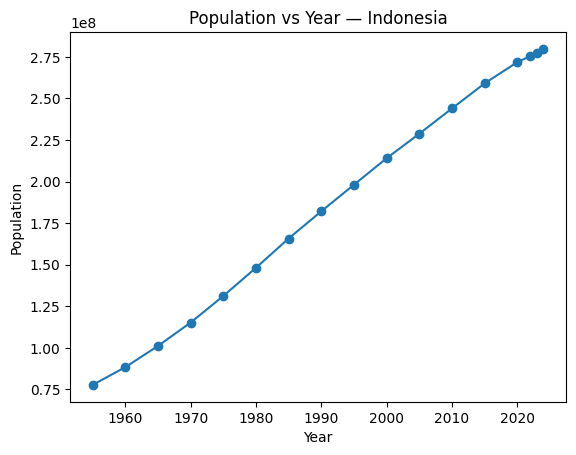

,Year,YearDiff
0,1955,NaN
1,1960,5.0
2,1965,5.0
3,1970,5.0
4,1975,5.0
5,1980,5.0
6,1985,5.0
7,1990,5.0
8,1995,5.0
9,2000,5.0


In [10]:
plt.figure()
plt.plot(sub["Year"], sub["Population"], marker="o")
plt.title(f"Population vs Year — {COUNTRY}")
plt.xlabel("Year")
plt.ylabel("Population")
plt.show()

# Cek jarak antar tahun (apakah tahunan / loncat per 5 tahun)
sub["YearDiff"] = sub["Year"].diff()
sub[["Year", "YearDiff"]].head(12)


## 5) EDA (Exploratory Data Analysis)
EDA minimal untuk time series:
- Plot populasi terhadap tahun untuk melihat tren.
- Cek `YearDiff` untuk mengetahui pola sampling (tahunan atau loncat beberapa tahun).

Catatan:
Walaupun data observasi hanya di tahun-tahun tertentu, simulasi ODE akan dilakukan pada grid waktu yang rapat (`dt` kecil),
lalu hasilnya diinterpolasi ke titik tahun observasi.


## 6) Model matematis: Logistic Growth (ODE)

Model logistic:

\[
\frac{dP}{dt} = rP \left(1 - \frac{P}{K}\right)
\]

Keterangan:
- \(P(t)\): populasi pada waktu \(t\)
- \(r\): laju pertumbuhan (growth rate)
- \(K\): kapasitas dukung (carrying capacity)

Tujuan fitting:
mencari \(r\) dan \(K\) agar kurva simulasi \(P(t)\) mendekati data populasi.


In [11]:
def logistic_rhs(t, P, r, K):
    """Turunan dP/dt untuk model logistic."""
    return r * P * (1 - P / K)

def rk4_step(f, t, y, h, r, K):
    """Satu langkah RK4 untuk y' = f(t, y)."""
    k1 = f(t, y, r, K)
    k2 = f(t + h/2, y + h*k1/2, r, K)
    k3 = f(t + h/2, y + h*k2/2, r, K)
    k4 = f(t + h,   y + h*k3,   r, K)
    return y + (h/6)*(k1 + 2*k2 + 2*k3 + k4)

def simulate_population(t_obs, P0, r, K, dt=0.05):
    """
    Simulasi ODE logistic dari t_min ke t_max pada grid rapat (dt),
    lalu interpolasi ke titik waktu observasi t_obs.
    """
    t_min, t_max = float(np.min(t_obs)), float(np.max(t_obs))
    t_grid = np.arange(t_min, t_max + dt, dt)

    P_grid = np.zeros_like(t_grid, dtype=float)
    P_grid[0] = P0

    for i in range(1, len(t_grid)):
        P_grid[i] = rk4_step(logistic_rhs, t_grid[i-1], P_grid[i-1], dt, r, K)

    # Interpolasi hasil simulasi agar sesuai titik observasi
    return np.interp(t_obs, t_grid, P_grid)


## 7) Metode numerik: RK4
RK4 menghitung 4 estimasi gradien (k1–k4) di setiap langkah waktu `dt`,
lalu menggabungkannya untuk menghasilkan nilai berikutnya.

Karena data observasi hanya tersedia pada beberapa tahun (tidak rapat),
kita mensimulasikan ODE pada grid waktu rapat (`dt` kecil), lalu menggunakan interpolasi
untuk mendapatkan prediksi tepat pada tahun-tahun observasi.


In [12]:
t = sub["Year"].values.astype(float)
P = sub["Population"].values.astype(float)

# Waktu relatif untuk stabilitas numerik (mulai dari 0)
t_rel = t - t[0]
P0 = float(P[0])

print("t range:", t[0], "to", t[-1])
print("P0:", P0)


t range: 1955.0 to 2024.0
P0: 77741502.0


## 8) Menyiapkan variabel fitting
- `t_rel`: waktu relatif (agar angka waktu lebih kecil dan stabil secara numerik).
- `P0`: kondisi awal dari data (populasi pada tahun pertama).


In [13]:
# Split sederhana: beberapa titik terakhir sebagai test
n_test = 4 if len(t_rel) > 10 else max(1, len(t_rel)//5)

t_train, P_train = t_rel[:-n_test], P[:-n_test]
t_test,  P_test  = t_rel[-n_test:], P[-n_test:]

print("Train points:", len(t_train), "Test points:", len(t_test))


Train points: 13 Test points: 4


## 9) Membagi data train/test (opsional tapi bagus)
- Train dipakai untuk fitting parameter.
- Test dipakai untuk evaluasi error (RMSE) agar ada bukti validasi sederhana.


In [14]:
def loss(theta):
    r, K = theta

    # batasan sederhana agar parameter masuk akal
    if r <= 0:
        return 1e30
    if K <= np.max(P) * 0.9:  # K seharusnya tidak jauh di bawah data maksimum
        return 1e30

    pred = simulate_population(t_train, P0, r, K, dt=0.05)
    return np.mean((pred - P_train)**2)

# initial guess
r0 = 0.02
K0 = np.max(P) * 1.5

res = minimize(
    loss,
    x0=np.array([r0, K0]),
    bounds=[(1e-6, 1.0), (np.max(P), np.max(P)*100)]
)

r_hat, K_hat = res.x
print("success:", res.success)
print("r_hat:", r_hat)
print("K_hat:", K_hat)


success: True
r_hat: 0.03355494606868039
K_hat: 419698189.3751862


## 10) Fitting parameter (Estimasi r dan K)
Kita mencari parameter `r` dan `K` yang meminimalkan error kuadrat rata-rata (MSE)
antara populasi hasil simulasi (RK4) dan populasi data pada bagian train.

Hasilnya:
- `r_hat`: estimasi laju pertumbuhan
- `K_hat`: estimasi carrying capacity


COUNTRY: Indonesia
RMSE test: 193486021.05741164


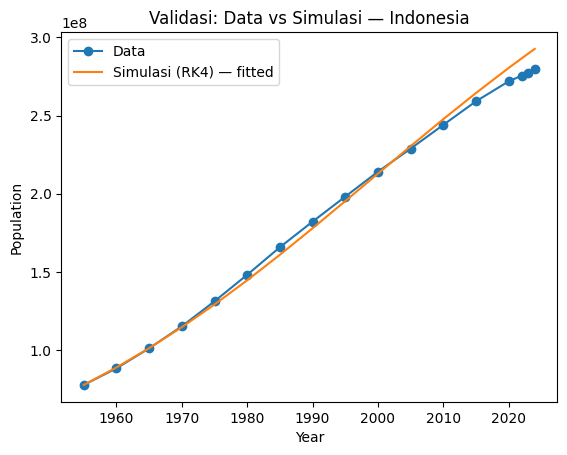

In [15]:
# Prediksi untuk semua titik observasi
P_fit_all = simulate_population(t_rel, P0, r_hat, K_hat, dt=0.05)

# Prediksi khusus test untuk RMSE
P_fit_test = simulate_population(t_test, P0, r_hat, K_hat, dt=0.05)
rmse_test = np.sqrt(np.mean((P_fit_test - P_test)**2))

print("COUNTRY:", COUNTRY)
print("RMSE test:", rmse_test)

plt.figure()
plt.plot(t, P, marker="o", label="Data")
plt.plot(t, P_fit_all, label="Simulasi (RK4) — fitted")
plt.title(f"Validasi: Data vs Simulasi — {COUNTRY}")
plt.xlabel("Year")
plt.ylabel("Population")
plt.legend()
plt.show()


## 11) Validasi hasil
Validasi dilakukan dengan:
- Menampilkan plot **Data vs Simulasi** pada waktu yang sama.
- Menghitung **RMSE** pada data test (jika train/test digunakan).

Jika kurva simulasi mengikuti tren data dan RMSE cukup kecil, parameter dianggap tervalidasi
untuk model logistic pada rentang data yang dipakai.


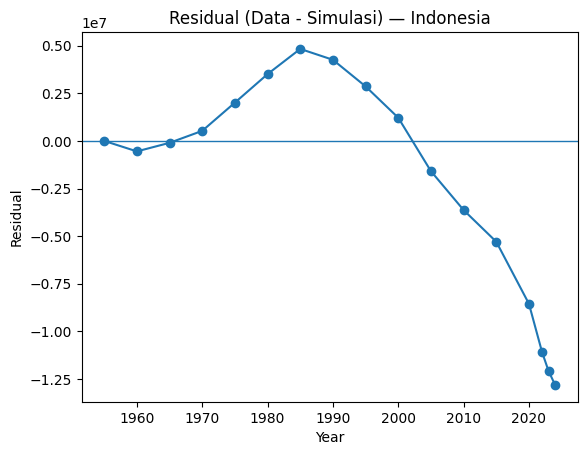

In [16]:
residual = P - P_fit_all

plt.figure()
plt.plot(t, residual, marker="o")
plt.axhline(0, linewidth=1)
plt.title(f"Residual (Data - Simulasi) — {COUNTRY}")
plt.xlabel("Year")
plt.ylabel("Residual")
plt.show()


## 12) Residual plot (opsional)
Residual = Data - Simulasi.
- Jika residual acak dan kecil → model cukup baik.
- Jika ada pola residual (misalnya selalu positif di akhir) → model mungkin terlalu sederhana
  atau parameter K/r belum menangkap perubahan tren.


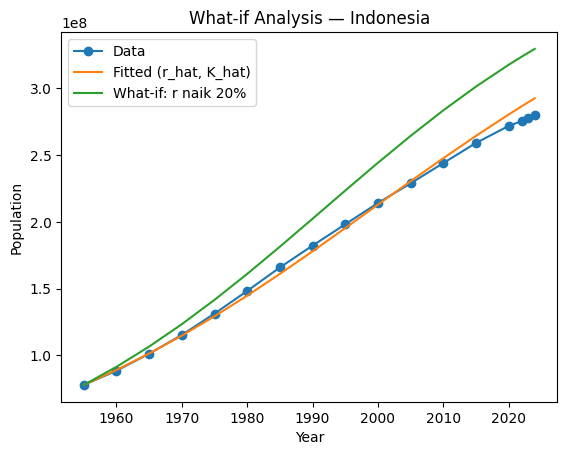

In [17]:
# What-if: r dinaikkan 20%, K tetap
r_try = r_hat * 1.2
K_try = K_hat
P_try = simulate_population(t_rel, P0, r_try, K_try, dt=0.05)

plt.figure()
plt.plot(t, P, marker="o", label="Data")
plt.plot(t, P_fit_all, label="Fitted (r_hat, K_hat)")
plt.plot(t, P_try, label="What-if: r naik 20%")
plt.title(f"What-if Analysis — {COUNTRY}")
plt.xlabel("Year")
plt.ylabel("Population")
plt.legend()
plt.show()


## 13) What-if analysis
Bagian ini menunjukkan bagaimana perubahan parameter memengaruhi dinamika populasi.

Contoh:
- menaikkan `r` meningkatkan laju pertumbuhan populasi.
Nantinya konsep ini dipakai di Streamlit (slider r dan K) untuk simulasi interaktif.
